In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-07 20:54:45.396538: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 20:54:46.790536: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 8200+30
end_idx = 8200+180
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(150, 96)

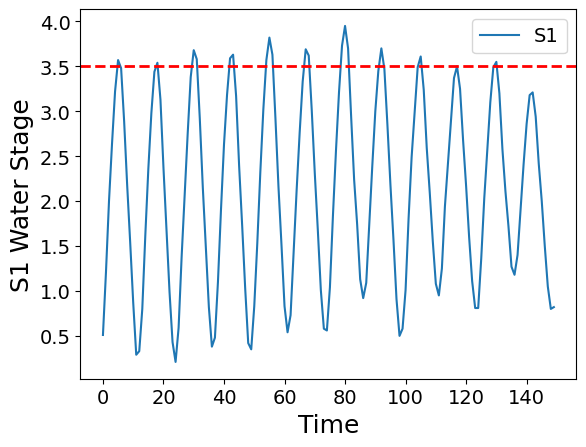

In [9]:
plt.plot(ws1[:, 0], label='S1')
plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Get optimizable and not optimizable variables

In [10]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [11]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(150, 96, 7)
(100800,)


In [12]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(150, 96, 2)


In [13]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(150, 96, 3)


### GA

In [14]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv}, compile=False)
# load_model('cnn.h5', compile=False)

2023-08-07 20:54:56.665783: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1


In [15]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [16]:
fitness_function = fitness_func

num_generations = 500
num_parents_mating = 8
sol_per_pop = 64


num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [17]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [18]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-07 20:54:59.303221: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step
CPU time: 9926.37677938817 seconds


In [19]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

5/5 [==============================] - 0s 4ms/step
Parameters of the best solution : [0.31802092 0.66108128 0.60754985 ... 0.56036554 0.13105924 0.5836713 ]
Fitness value of the best solution = 6.148617439831884e-05


### Post-processing

In [20]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

5/5 [==============================] - 0s 3ms/step


In [21]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

1780


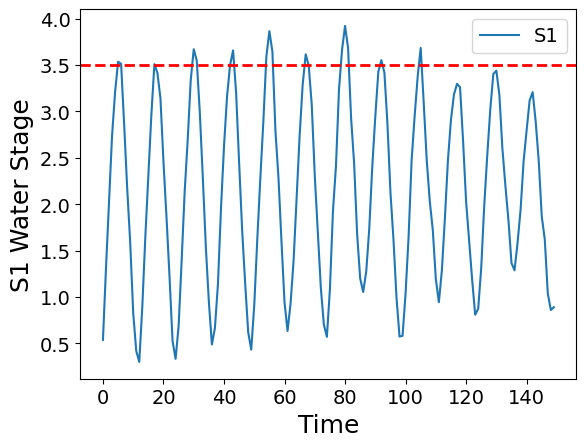

In [22]:
plt.plot(best_perf[:, 0], label='S1')
plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [23]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event2.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.318021,0.661081,0.607550,0.422021,0.377795,0.341363,0.408793,0.376448,0.077461,0.527037,...,0.898659,0.461838,0.559163,0.446986,0.082228,0.847156,0.900538,0.755452,0.735943,0.273769
1,0.713919,0.169961,0.555900,0.744417,0.930264,0.151368,0.919127,0.128139,0.449794,0.586003,...,0.052334,0.982310,0.428787,0.556523,0.776286,0.127256,0.164175,0.915944,0.820258,0.296908
2,0.876156,0.163107,0.953696,0.469955,0.379611,0.603210,0.124383,0.574139,0.201268,0.409775,...,0.868093,0.968702,0.144633,0.616395,0.875624,0.069600,0.154684,0.311845,0.107859,0.769727
3,0.104668,0.940812,0.999725,0.421407,0.907854,0.795979,0.245748,0.784794,0.387393,0.222956,...,0.380868,0.995865,0.071813,0.831831,0.281478,0.926355,0.052991,0.586945,0.227738,0.881006
4,0.541297,0.004809,0.494196,0.807964,0.467461,0.288422,0.101644,0.467234,0.482531,0.878635,...,0.732257,0.341817,0.691216,0.664711,0.517776,0.222061,0.505857,0.729758,0.074758,0.469664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.928986,0.263453,0.294101,0.322356,0.263716,0.310485,0.011339,0.011965,0.792503,0.310890,...,0.441732,0.415142,0.290443,0.303947,0.065834,0.791306,0.594615,0.533323,0.919243,0.149891
146,0.417546,0.997092,0.197567,0.861285,0.933919,0.371362,0.159576,0.949871,0.967041,0.964317,...,0.260542,0.410711,0.542759,0.612048,0.048527,0.372737,0.657605,0.794813,0.023064,0.026181
147,0.589628,0.549012,0.523199,0.797353,0.486699,0.247649,0.457681,0.865906,0.023743,0.300940,...,0.511001,0.529979,0.523360,0.308676,0.711202,0.809822,0.082734,0.995205,0.471881,0.855530
148,0.693684,0.649488,0.947908,0.164287,0.020394,0.224829,0.424445,0.798761,0.324830,0.318961,...,0.045908,0.200932,0.396870,0.865847,0.813205,0.324599,0.475838,0.462195,0.306182,0.177391


In [24]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event2.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.538439,0.382448,0.565166,0.547220,1.246080,1.110817,1.186662,1.125824,2.202471,2.278021,...,2.110999,2.020349,1.169032,1.464680,1.430436,1.371544,0.670017,0.760002,0.963982,0.803909
1,1.306441,1.241993,1.350250,1.330395,2.039655,1.865085,2.088948,2.089939,2.688056,2.409919,...,1.366093,1.299585,0.629692,0.879245,0.886970,0.774673,0.420266,0.567932,0.696124,0.551069
2,2.007766,1.867450,1.970204,2.022604,2.682047,2.864595,2.589765,2.682302,3.270633,3.112915,...,0.732451,0.656806,0.435635,0.444584,0.519376,0.514443,0.521755,0.727108,0.595636,0.565380
3,2.732117,3.016670,2.801663,2.792274,3.279933,3.124954,3.201235,3.318618,3.590928,3.253252,...,0.518439,0.429348,0.576087,0.568809,0.703029,0.543686,1.373504,1.662797,1.506539,1.467064
4,3.204200,3.054977,3.216716,3.281638,3.489611,3.358422,3.429517,3.583382,3.442339,3.210849,...,0.707895,0.585477,1.314687,1.483498,1.444896,1.446543,2.028038,2.235218,2.113936,2.103142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1.870505,1.947750,1.880473,1.949727,1.570617,1.282134,1.601195,1.620719,1.099165,1.162706,...,2.886365,2.995839,2.930138,3.093412,2.999427,3.096151,2.690752,2.740854,2.853580,2.909178
146,1.618966,1.503486,1.699772,1.762319,1.160858,1.152736,1.266478,1.224493,0.970112,0.951926,...,2.963622,3.076048,2.763275,2.806361,2.808039,2.897193,2.338972,2.568965,2.446821,2.486739
147,1.037160,1.317504,1.141586,1.043481,0.930458,1.017591,1.046717,0.942884,0.921629,0.965553,...,2.833970,2.931971,2.362289,2.497723,2.434244,2.494072,1.982290,2.011849,2.256747,2.198237
148,0.859898,0.973454,0.969125,0.774520,0.835540,1.180941,0.802253,0.748164,1.319263,1.498692,...,2.457444,2.526544,1.787474,2.179412,1.865098,1.969539,1.526379,1.872811,1.739262,1.709456


In [25]:
Optimal_case = pd.read_csv("GA_results/best_performance_event2.csv")
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.538439,0.382448,0.565166,0.547220,1.246080,1.110817,1.186662,1.125824,2.202472,2.278021,...,2.110999,2.020349,1.169032,1.464680,1.430436,1.371544,0.670017,0.760002,0.963982,0.803910
1,1.306441,1.241993,1.350250,1.330395,2.039655,1.865085,2.088948,2.089939,2.688056,2.409918,...,1.366093,1.299585,0.629692,0.879245,0.886970,0.774673,0.420266,0.567932,0.696124,0.551069
2,2.007766,1.867450,1.970204,2.022604,2.682047,2.864595,2.589765,2.682301,3.270633,3.112915,...,0.732451,0.656806,0.435635,0.444584,0.519376,0.514443,0.521755,0.727108,0.595636,0.565380
3,2.732117,3.016671,2.801663,2.792274,3.279933,3.124954,3.201235,3.318618,3.590928,3.253252,...,0.518439,0.429348,0.576087,0.568809,0.703029,0.543686,1.373504,1.662797,1.506539,1.467064
4,3.204200,3.054977,3.216716,3.281638,3.489611,3.358422,3.429517,3.583382,3.442339,3.210849,...,0.707895,0.585477,1.314687,1.483497,1.444896,1.446543,2.028038,2.235218,2.113936,2.103142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1.870505,1.947750,1.880473,1.949727,1.570617,1.282134,1.601195,1.620719,1.099165,1.162706,...,2.886365,2.995839,2.930138,3.093412,2.999427,3.096151,2.690752,2.740854,2.853581,2.909178
146,1.618966,1.503486,1.699772,1.762319,1.160858,1.152736,1.266478,1.224493,0.970112,0.951926,...,2.963622,3.076048,2.763275,2.806361,2.808039,2.897193,2.338972,2.568965,2.446821,2.486739
147,1.037160,1.317504,1.141586,1.043481,0.930458,1.017591,1.046717,0.942884,0.921629,0.965553,...,2.833970,2.931971,2.362289,2.497723,2.434244,2.494072,1.982290,2.011849,2.256747,2.198237
148,0.859898,0.973454,0.969125,0.774520,0.835539,1.180940,0.802253,0.748164,1.319263,1.498692,...,2.457444,2.526544,1.787474,2.179412,1.865098,1.969539,1.526379,1.872811,1.739262,1.709456


In [26]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)

time steps: 1780, areas: 373.961701
time steps: 0, areas: 0


In [27]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

5/5 [==============================] - 0s 3ms/step
time steps: 1808, areas: 357.91837334632874
time steps: 0, areas: 0
